In [1]:
# Import necessary libraries.
import os
import sys
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
import  re
from collections import Counter
import brewer2mpl
import matplotlib 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

clr = brewer2mpl.get_map('Set1', 'qualitative', 7).mpl_colors
%matplotlib inline

# 1. Prepare Data

In [2]:
# CSV file containing the labels.
emotion = pd.read_csv("/home/rudraksh/Datasets/Face_emotions/fer2013/fer2013.csv")

# Image properties.
image_size = 48

# Location of image files.
loc = "/home/rudraksh/Datasets/Face_emotions/fer2013/"

# Read image files.
def load_pic(folder):
    """ Loads all the images file from a folder into an array. """
    image_files = sorted(os.listdir(folder), key=lambda x: (int(re.sub('\D','',x)),x))
    dataset = np.ndarray(
        shape=(len(image_files), image_size, image_size),
        dtype=np.float32)
    
    num_images = 0
    for image in image_files:
        image_file = os.path.join(folder, image)
        image_data = ndimage.imread(image_file).astype(float)
        dataset[num_images, :, :] = image_data
        num_images += 1
    
    dataset = dataset[0:num_images, :, :]
    return dataset

# Load training, validation and testing image files.
train = load_pic(loc + 'Training')
valid = load_pic(loc + 'PublicTest')
test = load_pic(loc + 'PrivateTest')

# Labels for image files.
emotion =  emotion['emotion'].tolist()
train_labels = emotion[0:len(train)]
valid_labels = emotion[len(train): len(train) + len(valid)]
test_labels = emotion[len(train) + len(valid): len(train) + len(valid) + len(test)]

In [3]:
def preprocess(X,y):
    y_ = []
    X_ = np.ndarray(
        shape=(len(X), image_size, image_size),
        dtype=np.float32)
    
    num_images = 0
    for image,label in zip(X,y):
        
        # Normalizes image.
        mean = np.mean(image)
        std = np.std(image)
        mod_image = (image-mean) / std
        
        # Removes corrputed images.
        if not np.isnan(np.mean(mod_image)):
            X_[num_images,:,:] = mod_image
            y_.append(label)
            num_images += 1
            
    X = X_[0:num_images,:,:]
    y = y_
    return X,y

train, train_labels = preprocess(train,train_labels)
valid, valid_labels = preprocess(valid, valid_labels)            
test, test_labels = preprocess(test, test_labels)

/home/rudraksh/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: RuntimeWarning: invalid value encountered in divide


# 2. Data Exploration

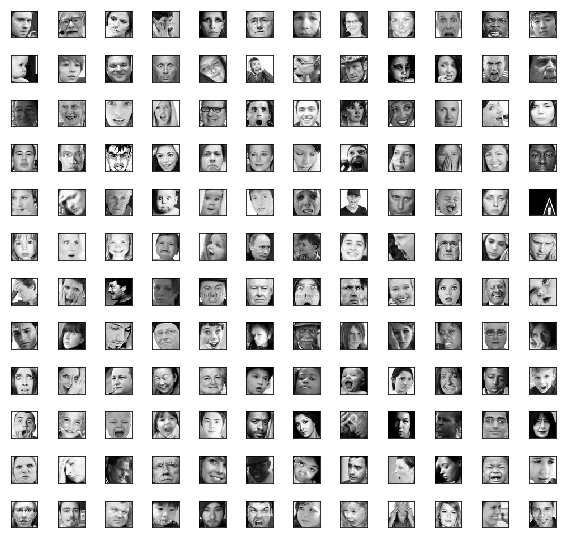

In [5]:
def image_grid(start, end, X):
    fig = plt.figure(figsize=(8,10))
    for i in range(start, end+1):
        input_img = X[i,:,:]
        ax = fig.add_subplot(16,12,i+1)
        ax.imshow(input_img, cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()
    
image_grid(0,143, train)

0


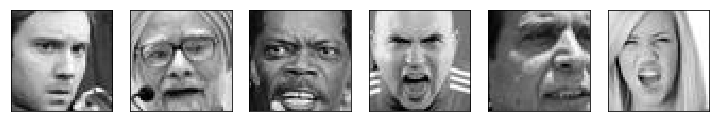

1


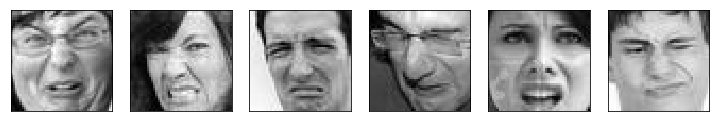

2


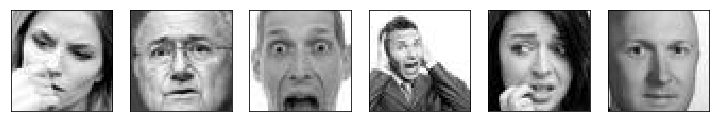

3


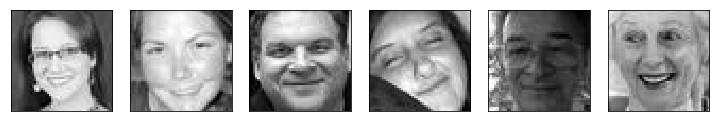

4


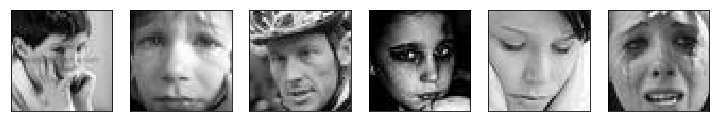

5


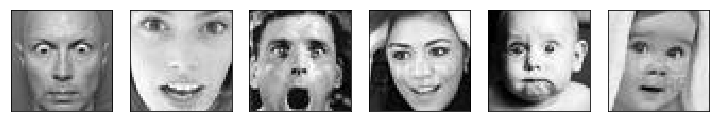

6


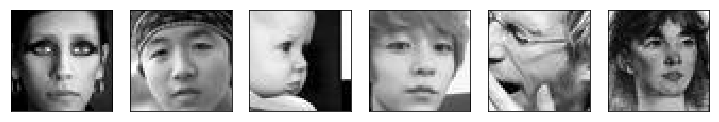

In [6]:
# Plots example images for the specified emotion.
def emotion_grid(X, X_lab, emotion, n):
    fig = plt.figure(figsize=(20,10))
    mod = train[[True if l == emotion else False for l in train_labels], :, :]
    for i in range(0, n):
        input_img = mod[i,:,:]
        ax = fig.add_subplot(4,12,i+1)
        ax.imshow(input_img, cmap=plt.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        plt.tight_layout()
    plt.show()

for i in range(7):
    print i
    emotion_grid(train, train_labels, i, 6)

### Visualize class distributions across training set.

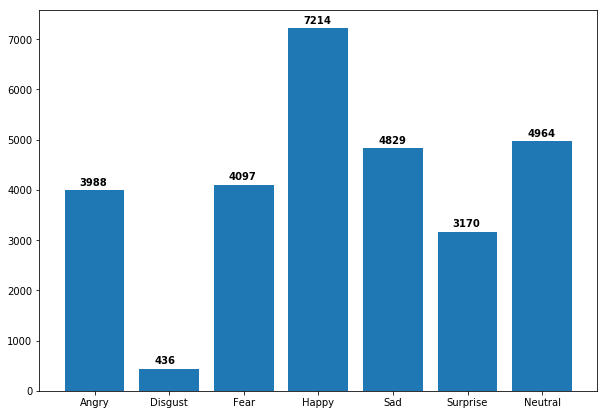

In [9]:
labels = Counter(train_labels).keys()
values = Counter(train_labels).values()

fig, ax = plt.subplots(figsize=(10,7)) 
ax.bar(labels, values)
plt.xticks(labels, ('Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral'))

for i, v in enumerate(values):
    ax.text(i-.2,v+100, str(v), color='black', fontweight='bold')

plt.show()

### Visualize distribution between training, testing and validation set.

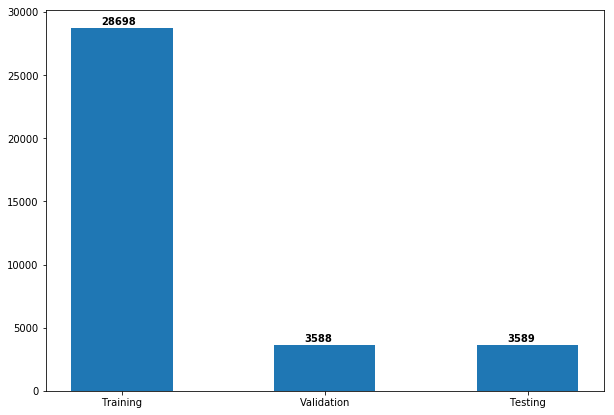

In [10]:
labels = ('Training', 'Validation', 'Testing')
l = np.arange(len(labels))
values = (len(train_labels), len(valid_labels),len(test_labels))


fig, ax = plt.subplots(figsize=(10,7)) 
ax.bar(l, values, width=.5)
plt.xticks(l, labels)

for i, v in enumerate(values):
    ax.text(i-.1,v+300, str(v), color='black', fontweight='bold')

plt.show()

# 3. Model Architecture

In [22]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
from keras_tqdm import TQDMNotebookCallback

def define_model():
    model = Sequential()

    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(48, 48, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(7, activation='softmax'))

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [37]:
cnn = define_model()
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 46, 46, 16)        160       
_________________________________________________________________
batch_normalization_8 (Batch (None, 46, 46, 16)        64        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 44, 44, 16)        2320      
_________________________________________________________________
batch_normalization_9 (Batch (None, 44, 44, 16)        64        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 22, 22, 16)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 22, 22, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 20, 20, 32)        4640      
__________

# 4. Training

## Without Data Augmentation

In [ ]:
from keras.callbacks import CSVLogger

csvlogger = CSVLogger('model1.log')
cnn.fit(train.reshape(len(train),48,48,1), train_labels,
        batch_size=128, 
        epochs=30,
        verbose= 2,
        callbacks = [csvlogger],
        validation_data=(valid.reshape(len(valid),48,48,1), valid_labels))

In [ ]:
cnn.save('/home/rudraksh/Data Science/ClassifyFaces/WithoutAugmentation')

In [63]:
from keras.models import load_model
cnn = load_model('/home/rudraksh/Data Science/ClassifyFaces/WithoutAugmentation')
cnn.evaluate(test.reshape(len(test), 48, 48, 1), test_labels)

3552/3589 [============================>.] - ETA: 0s  

[1.0634900953949711, 0.58902201171072788]

## With Data Augmentation

In [6]:
from keras.preprocessing.image import ImageDataGenerator

augmentGen = ImageDataGenerator(
    rotation_range = 40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    horizontal_flip=True)
augmentGen.fit(train.reshape(len(train),48,48,1))
augmentGen = augmentGen.flow(batch_size = 64, x=train.reshape(len(train),48,48,1), y=train_labels)

In [9]:
# We output to terminal. This is because the jupyter notebook crashes due to very frequent output messages.
sys.stdout = open('/dev/stdout', 'w')

csvlogger = CSVLogger('model2.log')
cnn = define_model()
cnn.fit_generator(augmentGen, 
                  steps_per_epoch=len(train_labels), 
                  epochs=10,
                  verbose=1,
                  callbacks = [csvlogger],
                  validation_data=(valid.reshape(len(valid), 48, 48, 1), valid_labels))

sys.stdout.close()

In [12]:
cnn.evaluate(test.reshape(len(test), 48, 48, 1), test_labels)

[1.0002657028917283, 0.6216216216382292]

# 5. Analysis of Model (s)

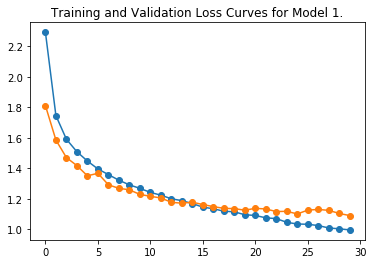

In [3]:
# Plot validation and training error curves for model 1.
model1 = pd.read_csv('model1.log')
plt.plot(model1.epoch, model1.loss, '-o')
plt.plot(model1.epoch, model1.val_loss, '-o')
plt.title('Training and Validation Loss Curves for Model 1.')
plt.show()

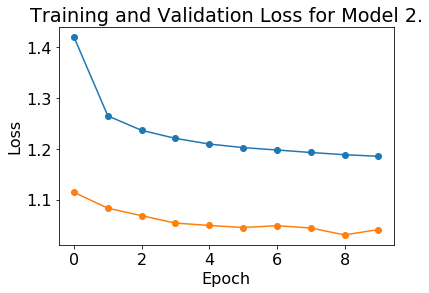

In [56]:
# Plot validation and training error curves for model 1.
model2 = pd.read_csv('model2.log')
plt.plot(model2.epoch,model2.loss,'-o')
plt.plot(model2.epoch, model2.val_loss, '-o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for Model 2.')
plt.show()

In [4]:
from keras.models import load_model
cnn = load_model('/home/rudraksh/Data Science/ClassifyFaces/WithAugmentation')

y_pred = cnn.predict_classes(x=test.reshape(len(test), 48, 48, 1))
y_true = test_labels
y_prob = cnn.predict_proba(x=test.reshape(len(test), 48, 48, 1))
X = test

Using TensorFlow backend.


3552/3589 [============================>.] - ETA: 0s 

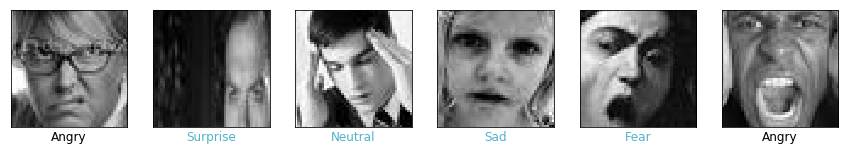

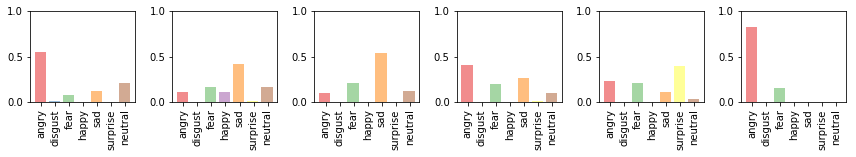

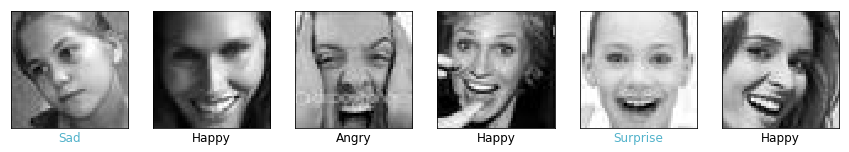

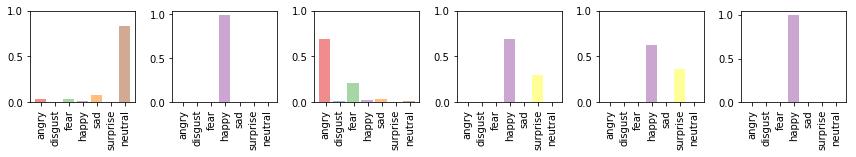

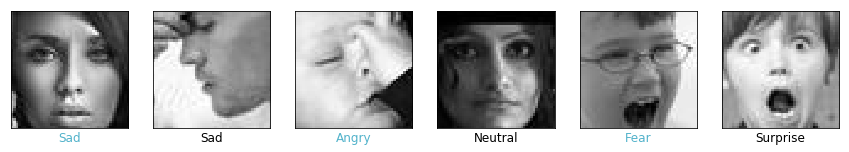

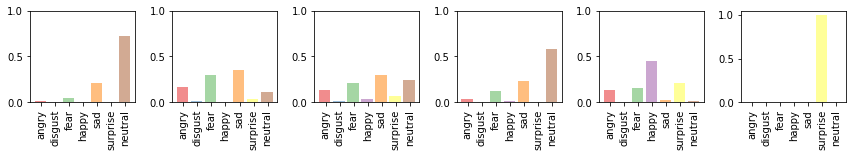

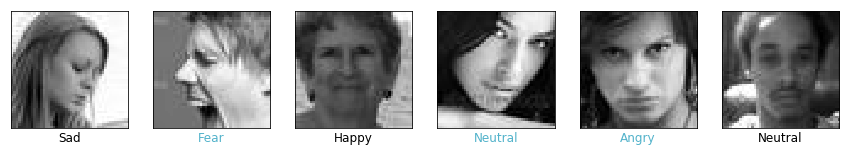

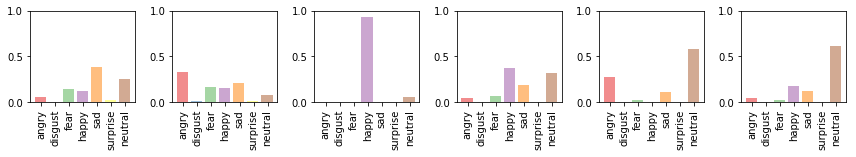

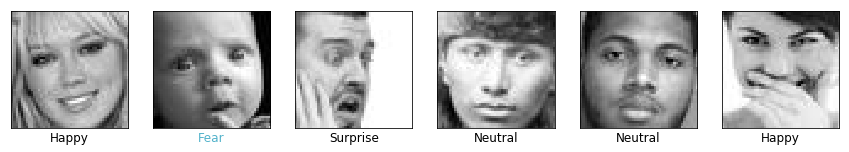

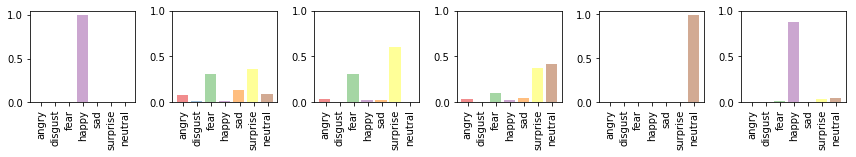

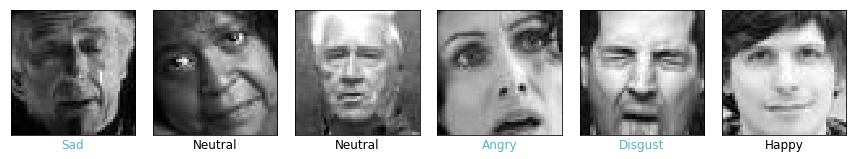

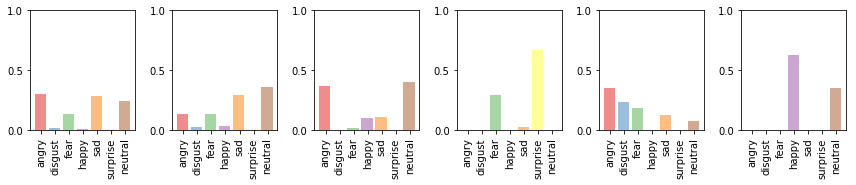

In [5]:
# Plots the images of people.
def plot_subjects(start, end, y_pred, y_true, title=False):
    fig = plt.figure(figsize=(12,12))
    emotion = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.imshow(input_img[0,:,:], cmap=matplotlib.cm.gray)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
        if y_pred[i] != y_true[i]:
            plt.xlabel(emotion[y_true[i]], color='#53b3cb',fontsize=12)
        else:
            plt.xlabel(emotion[y_true[i]], fontsize=12)
        if title:
            plt.title(emotion[y_pred[i]], color='blue')
        plt.tight_layout()
    plt.show()

# Plots the probabilities of emotions as predicted by the model.
def plot_probs(start,end, y_prob):
    fig = plt.figure(figsize=(12,12))
    for i in range(start, end+1):
        input_img = X[i:(i+1),:,:]
        ax = fig.add_subplot(6,6,i+1)
        ax.bar(np.arange(0,7), y_prob[i,:], alpha=0.5, color = clr)
        ax.set_xticks(np.arange(0.05,7.05,1))
        labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise','neutral']
        ax.set_xticklabels(labels, rotation=90, fontsize=10)
        ax.set_yticks(np.arange(0.0,1.1,0.5))
        plt.tight_layout()
    plt.show()

# Combines the above 2 functions to plot the image as well as corresponding bar chart 
# reprsenting probabilities for various emotions.
def plot_subjects_with_probs(start, end, y_prob):
    iter = (end - start)/6
    for i in np.arange(0,iter):
        plot_subjects(i*6,(i+1)*6-1, y_pred, y_true, title=False)
        plot_probs(i*6,(i+1)*6-1, y_prob)

plot_subjects_with_probs(0, 36, y_prob)

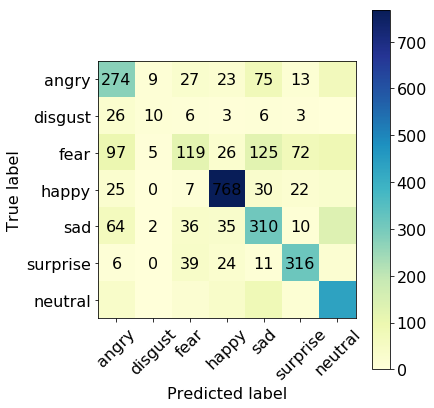

In [9]:
# Plots the confusion matrix.
def plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(7,7))
    matplotlib.rcParams.update({'font.size': 16})
    ax  = fig.add_subplot(111)
    matrix = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    fig.colorbar(matrix) 
    for i in range(0,7):
        for j in range(0,7):  
            ax.text(j,i,cm[i,j],va='center', ha='center')
    labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise','neutral']
    ticks = np.arange(len(labels))
    ax.set_xticks(ticks)
    ax.set_xticklabels(labels, rotation=45)
    ax.set_yticks(ticks)
    ax.set_yticklabels(labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
plot_confusion_matrix(y_true, y_pred, cmap=plt.cm.YlGnBu)

In [12]:
labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise','neutral']

def class_precision(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    col = [cm[j,i] for j in range(0,7)]
    return float(col[i])/sum(col)

def class_recall(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    row = [cm[i,j] for j in range(0,7)]
    return float(row[i])/sum(row)

def class_accuracy(y_true, y_pred, emotion):
    cm = confusion_matrix(y_true, y_pred)
    i = [i for i, label in enumerate(labels) if label == emotion][0]
    tp = cm[i,i]
    fn = sum([cm[i,j] for j in range(0,7) if j != i])
    fp = sum([cm[j,i] for j in range(0,7) if j != i])
    tn = sum([cm[i,j] for j in range(0,7) for i in range(0,7)]) -(tp+fp+fn)
    return float(tp + tn)/sum([tp, fn, fp, tn])

for emotion in labels:
    print emotion.upper()
    print '   acc = {}'.format(class_accuracy(y_true, y_pred, emotion))
    print '  prec = {}'.format(class_precision(y_true, y_pred, emotion))
    print 'recall = {}\n'.format(class_recall(y_true, y_pred, emotion))
    
print classification_report(y_true, y_pred, target_names=labels)

ANGRY
   acc = 0.868487043745
  prec = 0.517958412098
recall = 0.558044806517

DISGUST
   acc = 0.982724993034
  prec = 0.37037037037
recall = 0.181818181818

FEAR
   acc = 0.848425745333
  prec = 0.468503937008
recall = 0.225378787879

HAPPY
   acc = 0.927556422402
  prec = 0.837513631407
recall = 0.873720136519

SAD
   acc = 0.82892170521
  prec = 0.484375
recall = 0.521885521886

SURPRISE
   acc = 0.935079409306
  prec = 0.703786191537
recall = 0.759615384615

NEUTRAL
   acc = 0.852047924213
  prec = 0.561448900388
recall = 0.693290734824

             precision    recall  f1-score   support

      angry       0.52      0.56      0.54       491
    disgust       0.37      0.18      0.24        55
       fear       0.47      0.23      0.30       528
      happy       0.84      0.87      0.86       879
        sad       0.48      0.52      0.50       594
   surprise       0.70      0.76      0.73       416
    neutral       0.56      0.69      0.62       626

avg / total       0.61   